In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv(filepath_or_buffer='../input/maang-stock-prices-july-2018-to-july-2023/combined_file.csv', )
df = df[df['Name'] != 'Name']
for column in ['Open', 'High', 'Low', 'Close', 'Adj Close']:
    df[column] = df[column].astype(float)
df['Volume'] = df['Volume'].astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date')
df.head()

,Name,Date,Open,High,Low,Close,Adj Close,Volume
0,AMZN,2018-07-30,91.366501,91.474998,88.301003,88.960999,88.960999,131246000
1,AMZN,2018-07-31,89.324501,90.091499,86.966003,88.872002,88.872002,114774000
2,AMZN,2018-08-01,89.199997,89.921997,88.801003,89.858498,89.858498,83062000
3,AMZN,2018-08-02,89.438499,91.828003,89.300003,91.716499,91.716499,87094000
4,AMZN,2018-08-03,91.887001,92.050003,91.074997,91.164497,91.164497,69210000


In [2]:
df.shape

(8806, 8)

In [3]:
df.dtypes

Name                 object
Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<Axes: xlabel='Date', ylabel='Volume'>

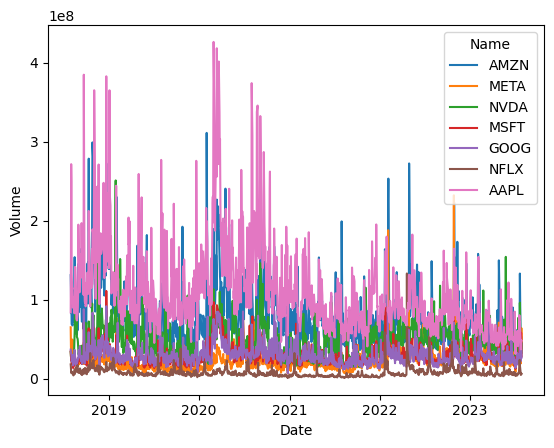

In [4]:
from seaborn import lineplot
lineplot(data=df, x='Date', y='Volume', hue='Name')

This is kind of messy; let's look at monthly volume instead

<Axes: xlabel='Date', ylabel='Volume'>

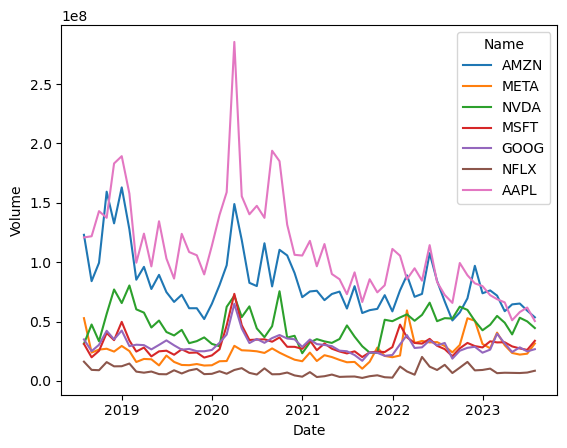

In [5]:
# we have daily volume, but monthly volume will give us a clearer picture
def get_monthly(arg_df, arg_name, value_name):
    result_df = arg_df[arg_df['Name'] == arg_name][[value_name]].resample('M').mean()
    result_df['Name'] = arg_name
    return result_df
monthly_volume_df = pd.concat([get_monthly(df[['Date', 'Name', 'Volume']].set_index('Date'), name, 'Volume') for name in df['Name'].unique()])
lineplot(data=monthly_volume_df, x='Date', y='Volume', hue='Name')

How big are the close adjustments?

In [6]:
df['Adj'] = df['Adj Close'] - df['Close']
